<h1 align="center">Ecommerce Analysis</h1>

## HDFS

### Creating `ecommerce` directory in hdfs
```bash
hdfs dfs -mkdir ecommerce
```

### Adding `ecommerce.csv` to hdfs
```bash
hdfs dfs -put ecommerce.csv ecommerce/
```

## PySpark

### importing packages
```python
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import happybase
```

### Creating SparkSession

```python
spark = SparkSession.builder.master("local[5]").appName("VarunSpark").enableHiveSupport().getOrCreate()
```
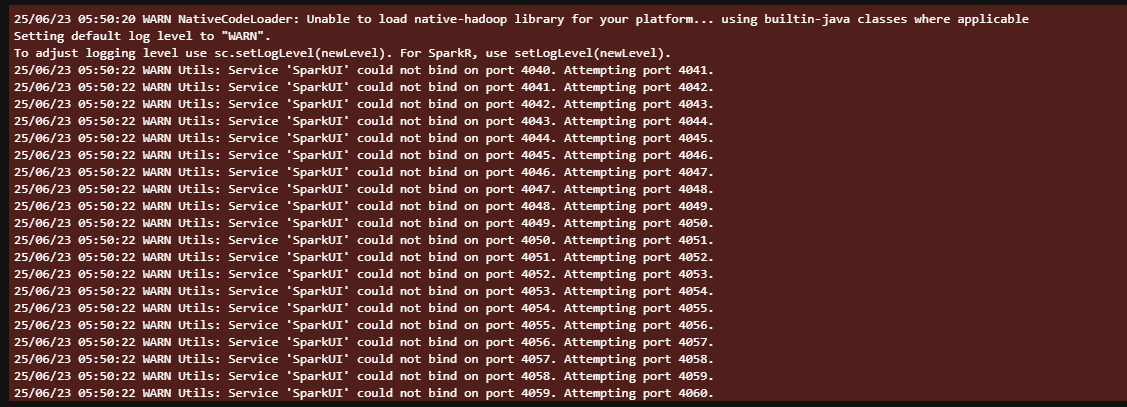

### reading CSV file

```python
ecommerce = spark.read.csv("ecommerce/ecommerce.csv", header=True, sep=',', inferSchema=True)
```

### TypeCasting `invoice_date` from `string` to `date`

```python
ecommerce = ecommerce.withColumn("InvoiceDate", ecommerce.InvoiceDate.cast(DateType()))
```

### Adding `total_amount` column in ecommerce table

```python
ecommerce = ecommerce.withColumn("total_amount", ecommerce.Quantity*ecommerce.UnitPrice)
```
### Checking for null values
```python
print(ecommerce.describe().show())
```

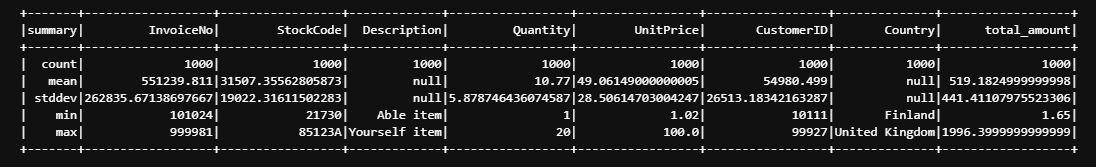


```python
null_counts = ecommerce.select([sum(col(c).isNull().cast('int')).alias(c) for c in ecommerce.columns])
print(null_counts.show())
```
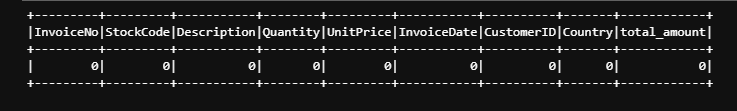

### Dropping if any null values are present
```python
ecommerce = ecommerce.dropna()
```
### Printing schema of `ecommerce` table
```python
print(ecommerce.printSchema())
```
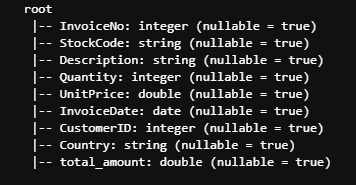

### Printing ecommerce table of first 10 rows
```python
print(ecommerce.show(10))
```
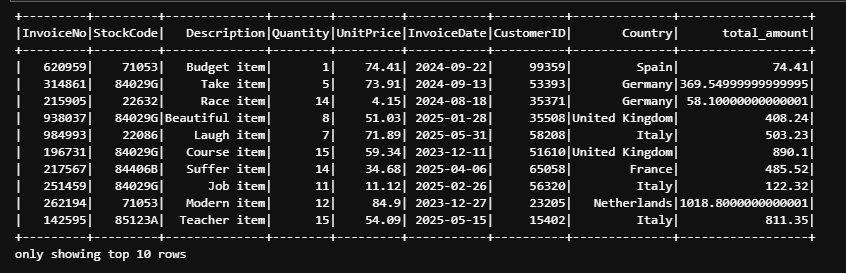

### Creating Hive external table
```sql
CREATE EXTERNAL TABLE `varunmdb.ecom_transactions`(
  InvoiceNo integer,
  StockCode string,
  Description string,
  Quantity integer,
  UnitPrice double,
  InvoiceDate date,
  CustomerID integer,
  total_amount DOUBLE)
partitioned by (Country string)
stored as PARQUET
LOCATION 'hdfs:///user/varunm15t38hedu/ecommerce/parquet';
```

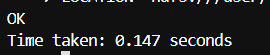

### writing as parquet to ecommerce/parquet partitioning by `country` column
```python
ecommerce.write.mode('overwrite').partitionBy('Country').parquet("hdfs:///user/varunm15t38hedu/ecommerce/parquet")
```

### check if files are partitioned correctly
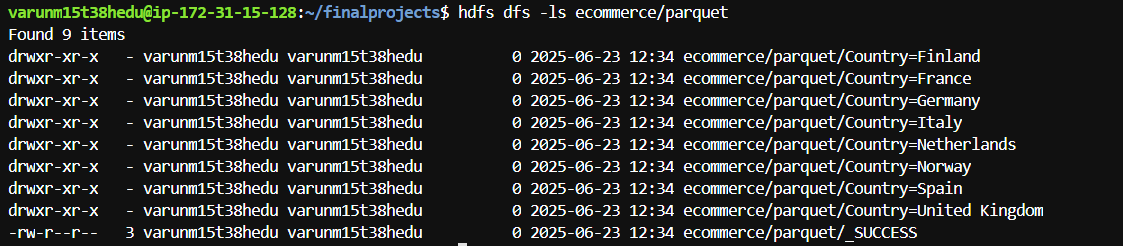

### reparing partitions
```python
spark.sql("msck repair table varunmdb.ecom_transactions")
```
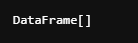

### reading table to check it is working
```python
df = spark.read.table("varunmdb.ecom_transactions")
```

### printing 10 rows of the table from hive
```python
print(spark.sql("select * from varunmdb.ecom_transactions limit 10").show())
```

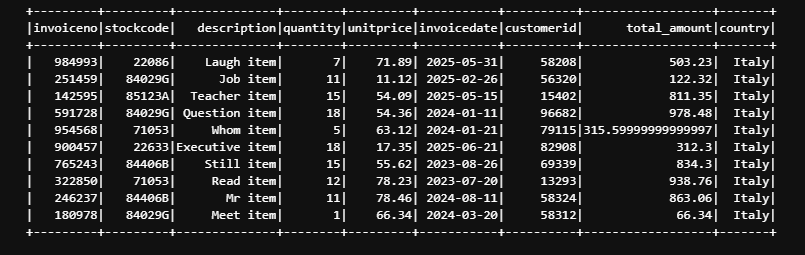

## HBASE

### Create hbase table in hbase shell

```bash
hbase shell
create 'varuntcs:ecom_txn' 'info'
```

### create connection with hbase table
```python
connection = happybase.Connection('master')
table = connection.table('varuntcs:ecom_txn')
```

### Inserting data into hbase for first 10 rows
```python
for row in ecommerce.limit(10).collect():
    row_key = f"{row.InvoiceNo}_{row.StockCode}"
    table.put(row_key.encode(), {
        b'info:InvoiceNo': str(row.InvoiceNo).encode(),
        b'info:StockCode': str(row.StockCode).encode(),
        b'info:Quantity': str(row.Quantity).encode(),
        b'info:UnitPrice': str(row.UnitPrice).encode(),
        b'info:CustomerID': str(row.CustomerID).encode(),
        b'info:InvoiceDate': str(row.InvoiceDate).encode(),
        b'info:total_amount': str(row.total_amount).encode(),
        b'info:Country': str(row.Country).encode()
    })
```

### printing sample rows
```python
sample_key = f"{row.InvoiceNo}_{row.StockCode}".encode()
print(table.row(sample_key))
```
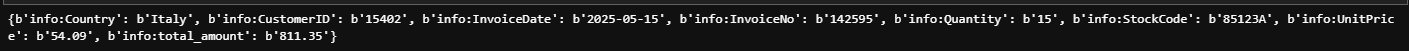

### count number of rows in hbase shell
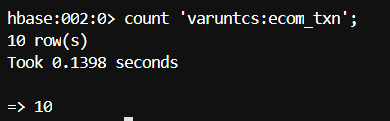

### check data available on hbase
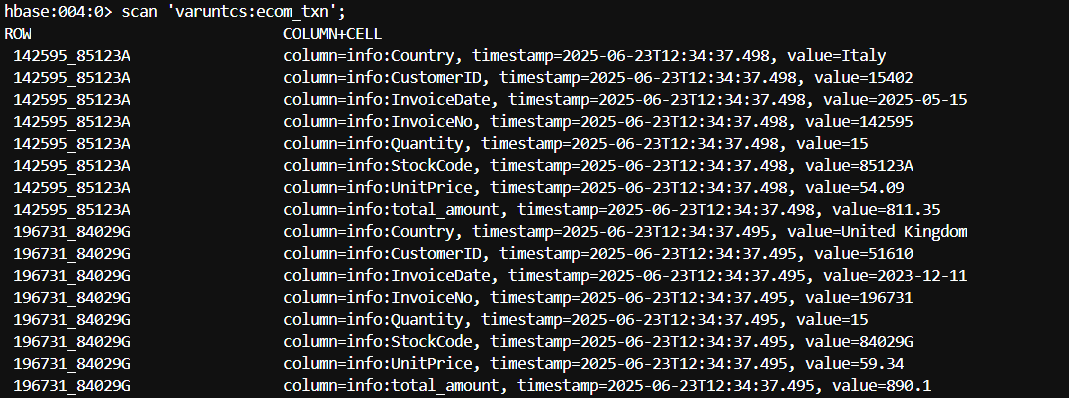

### 
### 1. Total sales per country
```python
print(ecommerce.groupBy("Country").count().alias("count").orderBy(col("count").desc()).show())
```
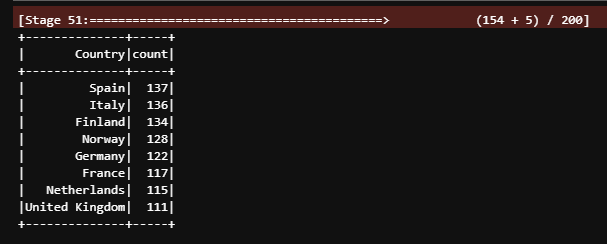

### 2. Monthly sales trend
```python
print(ecommerce.select(concat(year(col("InvoiceDate")),lit(" / "),month(col("InvoiceDate"))).alias("month"),col("total_amount")).groupBy("month").agg(round(sum(col("total_amount")),2).alias("total_amount")).orderBy(col("month").desc()).show())
```
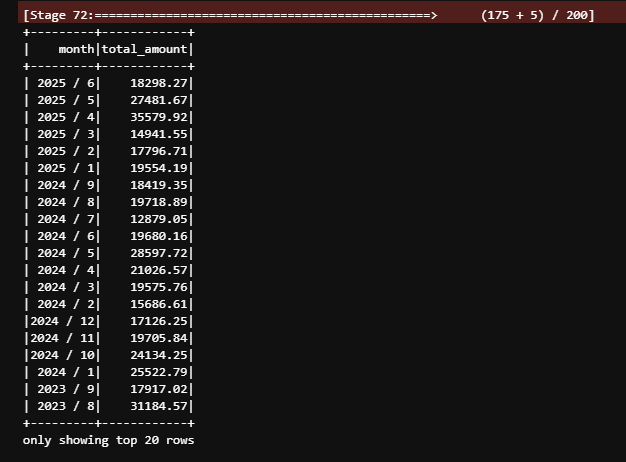

### 3. Top 10 most sold products
```python
print(ecommerce.select(["Description","Quantity"]).groupBy("Description").agg(sum(col("Quantity")).alias("Quantity")).orderBy(col("Quantity").desc()).show(10))
```
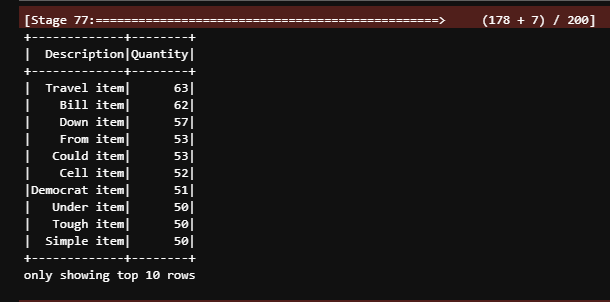

### 4. Total revenue
```python
print(ecommerce.select(round(sum("total_amount"),2).alias("total_amount")).show())
```
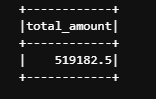

### 5. Average basket size
```python
print(ecommerce.select(col("InvoiceNo"),col("Quantity")).groupBy("InvoiceNo").agg(avg(col("Quantity")).alias("Quantity")).show())
```
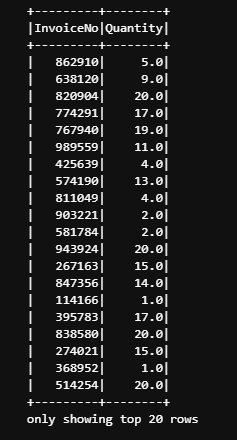


<h1 align="center">Thank You</h1>